In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from etl.util import prepare_dataset_without_leakage
from ml_features.features import prepare_features
from ml_features.customer_features import create_customer_features
from ml_features.sequence_features import create_sequence_features
from ml_training.train_rf import train_rf
from ml_evaluation.dashboard import model_evaluation_report
import warnings
from plotly.subplots import make_subplots
warnings.filterwarnings('ignore')


import wandb
import os

os.environ['WANDB_SILENT'] = 'false'

In [2]:
global wandb_run
wandb_run = wandb.init(
    project="france-hvac",
    # name="feature_engineering",
    config={"note": "Clean run"},
    # Only use settings that actually exist
    settings=wandb.Settings(
        _disable_stats=True,   # This one is confirmed to work
        silent=True           # Reduce output
    )
)

run_id = wandb_run.id
print(f"Run ID: {run_id}")



# run = wandb.init(
#     project="france-hvac",
#     name="feature_engineering",
#     config={
#         "_wandb": {
#             "python": os.environ['WANDB_PYTHON'],
#         }
#     },
#     settings=wandb.Settings(
#         _executable=os.environ['WANDB_PYTHON'],
#         _disable_meta=False,  # Keep meta but override values
#         disable_git=False,
#         silent=False
#     )
# )

# ======================================================

wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /home/valeriya/.netrc.


Run ID: rvt4eixs


In [3]:
# Load data
df_quotes = pd.read_csv('cleaned_quote_data.csv')
df_quotes['dt_creation_devis'] = pd.to_datetime(df_quotes['dt_creation_devis'])

print(f"\n📊 Original quote data: {len(df_quotes):,} quotes")

# Create features
enhanced_customers = create_customer_features(df_quotes)
sequence_df = create_sequence_features(df_quotes, window_days=90)
sequence_df = pd.merge(sequence_df, enhanced_customers, on='numero_compte', how='left')

X_customer = enhanced_customers.drop(columns=['numero_compte', 'converted'], errors='ignore')
y_customer = enhanced_customers['converted']
X_customer_clean, y_customer_clean = prepare_features(X_customer, y_customer, "Customer Features")

X_sequence = sequence_df.drop(columns=['numero_compte', 'current_converted', 'current_product_family', 'converted'], errors='ignore')
y_sequence = sequence_df['current_converted']
X_sequence_clean, y_sequence_clean = prepare_features(X_sequence, y_sequence, "Sequence Features")


📊 Original quote data: 38,333 quotes
Creating enhanced customer features...
  Total customers: 25,930
✓ Created features for 25,930 customers
✓ New features: ['numero_compte', 'total_quotes', 'converted', 'avg_days_between_quotes', 'std_days_between_quotes', 'max_days_between_quotes', 'engagement_density', 'price_trajectory', 'unique_product_families', 'product_consistency']...
Creating sequence features (this may take a moment)...
  Total customers: 25,930
✓ Created 10,723 sequence observations
✓ Features include: recent patterns leading up to each quote

🔧 ENCODING & PREPARING FOR MODELING...
  Preparing Customer Features...
  Features: 14, Samples: 25930

🔧 ENCODING & PREPARING FOR MODELING...
  Preparing Sequence Features...
  Features: 22, Samples: 10723


In [4]:
print("\n" + "="*80)
print("MODEL TRAINING WITH PROPER VISUALIZATIONS")
print("="*80)

# Function to create and log ROC curve
def plot_and_log_roc(y_true, y_pred_proba, model_name):
    """Create ROC curve and log to wandb"""
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    auc = roc_auc_score(y_true, y_pred_proba)
    
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc:.3f})')
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC Curve - {model_name}')
    ax.legend(loc="lower right")
    ax.grid(True, alpha=0.3)
    
    # Log to wandb
    # wandb.log({f"{model_name}/roc_curve": wandb.Image(fig)})
    plt.close(fig)
    
    return auc

# Function to create and log confusion matrix
def plot_and_log_confusion_matrix(y_true, y_pred, model_name):
    """Create confusion matrix and log to wandb"""
    cm = confusion_matrix(y_true, y_pred)
    
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['No Convert', 'Convert'],
                yticklabels=['No Convert', 'Convert'])
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title(f'Confusion Matrix - {model_name}')
    
    # Log to wandb
    plt.close(fig)
    
    return cm

# Test 1: Customer features
print("\n🧪 CUSTOMER FEATURES MODEL")
result_customer = train_rf(X_customer_clean, y_customer_clean, 'customer_model')

# Create predictions for visualizations
X_train, X_test, y_train, y_test = train_test_split(
    X_customer_clean, y_customer_clean, test_size=0.2, random_state=42
)
y_pred = result_customer['model'].predict(X_test)


MODEL TRAINING WITH PROPER VISUALIZATIONS

🧪 CUSTOMER FEATURES MODEL
✓ Model saved: customer_model.pkl
✓ AUC: 0.675


In [5]:
y_pred_proba = result_customer['model'].predict_proba(X_test)[:, 1]

In [12]:

import wandb
import plotly.graph_objects as go
import plotly.io as pio
from sklearn.metrics import roc_curve, auc
from contextlib import redirect_stdout, redirect_stderr
import io

import os
# os.environ['WANDB_SILENT'] = 'true'

import wandb

# Initialize with minimal settings
wandb.init(
    project="france-hvac",
    id=run_id,
    resume="allow",
    settings=wandb.Settings(quiet=True)
)


#wandb.init(project="france-hvac", id=run_id, resume="allow")


# Initialize wandb
print(run_id)
# wandb.init(project="france-hvac", id=run_id, resume="allow",  settings=wandb.Settings(
#         console='off',      # 'off', 'wrap', 'redirect'
#         _disable_stats=True,
#         _disable_meta=True,
#         _disable_viewer=True
#     ), )
# with redirect_stdout(io.StringIO()), redirect_stderr(io.StringIO()):
# wandb.init(project="france-hvac", id=run_id, resume="allow")
# import wandb
# import sys
# import io

# def silent_wandb_init(**kwargs):
#     """Initialize wandb without printing to console"""
#     # Save current stdout
#     old_stdout = sys.stdout
#     old_stderr = sys.stderr
    
#     # Redirect to string buffer
#     sys.stdout = io.StringIO()
#     sys.stderr = io.StringIO()
    
#     try:
#         run = wandb.init(**kwargs)
#         return run
#     finally:
#         # Restore stdout/stderr
#         sys.stdout = old_stdout
#         sys.stderr = old_stderr

# # Use the silent function
# run = silent_wandb_init(
#     project="france-hvac",
#     id=run_id,
#     resume="allow"
# )


# import os
# os.environ['WANDB_SILENT'] = 'true'
# os.environ['WANDB_CONSOLE'] = 'off'

# import wandb

# # This will be silent
#wandb.init(project="france-hvac", id=run_id, resume="allow")



# Calculate ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# ============ CREATE FULLY CUSTOMIZED PLOT ============
# fig = go.Figure()
fig = make_subplots(rows=1, cols=1)

# 1. Model ROC curve with custom styling
fig.add_trace(go.Scatter(
    x=fpr,
    y=tpr,
    mode='lines',  # 'lines', 'lines+markers', 'markers'
    name=f'Model (AUC = {roc_auc:.3f})',
    line=dict(
        color='#FF6B6B',  # Hex color
        width=4,          # Line thickness
        dash='solid'      # 'solid', 'dash', 'dot', 'dashdot'
    ),
    hovertemplate=(
        'FPR: %{x:.3f}<br>' +
        'TPR: %{y:.3f}<br>' +
        '<extra></extra>'  # Hides trace name from hover
    ),
    showlegend=True
), row=1, col=1)

# 2. Random classifier with custom styling
fig.add_trace(go.Scatter(
    x=[0, 1],
    y=[0, 1],
    mode='lines',
    name='Random (AUC = 0.500)',
    line=dict(
        color='#4ECDC4',
        width=3,
        dash='dash'
    ),
    showlegend=True
), row=1, col=1)

# 3. Optional: Perfect classifier
fig.add_trace(go.Scatter(
    x=[0, 0, 1],
    y=[0, 1, 1],
    mode='lines',
    name='Perfect (AUC = 1.000)',
    line=dict(
        color='#45B7D1',
        width=2,
        dash='dot'
    ),
    showlegend=True
), row=1, col=1)

# ============ CUSTOMIZE LAYOUT ============
fig.update_layout(
    # Size
    width=700,   # pixels
    height=700,
    
    # Title
    title=dict(
        text="<b>ROC Curve Analysis</b>",
        font=dict(
            family="Arial",
            size=24,
            color="#2C3E50"
        ),
        x=0.5,  # Center title
        xanchor="center"
    ),
    
    # Axes
    xaxis=dict(
        title=dict(
            text="<b>False Positive Rate</b>",
            font=dict(size=16, color="#34495E")
        ),
        range=[-0.02, 1.02],  # Extend slightly beyond 0-1
        gridcolor='lightgray',
        gridwidth=1,
        zerolinecolor='gray',
        showline=True,
        linewidth=2,
        linecolor='black',
        tickfont=dict(size=12)
    ),
    
    yaxis=dict(
        title=dict(
            text="<b>True Positive Rate</b>",
            font=dict(size=16, color="#34495E")
        ),
        range=[-0.02, 1.02],
        gridcolor='lightgray',
        gridwidth=1,
        zerolinecolor='gray',
        showline=True,
        linewidth=2,
        linecolor='black',
        tickfont=dict(size=12)
    ),
    
    # Legend
    legend=dict(
        x=0.02,  # Left position
        y=0.98,  # Top position
        bgcolor='rgba(255, 255, 255, 0.8)',
        bordercolor='gray',
        borderwidth=1,
        font=dict(size=14)
    ),
    
    # Background
    plot_bgcolor='white',
    paper_bgcolor='white',
    
    # Margins
    margin=dict(l=0, r=0, t=0, b=8),
    
    # Hover behavior
    hovermode='x unified',  # 'x', 'y', 'closest', False
    
    # Shapes (add reference areas)
    shapes=[
        # Good performance area
        dict(
            type="rect",
            xref="x", yref="y",
            x0=0, x1=0.2,
            y0=0.8, y1=1,
            fillcolor="rgba(0, 255, 0, 0.1)",
            line=dict(width=0),
            layer="below"
        ),
        # Random area
        dict(
            type="rect",
            xref="x", yref="y",
            x0=0, x1=1,
            y0=0, y1=1,
            fillcolor="rgba(128, 128, 128, 0.05)",
            line=dict(width=0),
            layer="below"
        )
    ],
    
    # Annotations (add text)
    annotations=[
        dict(
            x=0.6,
            y=0.3,
            text=f"<b>AUC = {roc_auc:.3f}</b>",
            showarrow=True,
            arrowhead=2,
            ax=50,
            ay=-40,
            font=dict(size=16, color="#FF6B6B"),
            bgcolor="white",
            bordercolor="#FF6B6B",
            borderwidth=2,
            borderpad=4
        )
    ]
)

# ============ CUSTOMIZE MODEBAR CONTROLS ============
# Show/hide specific controls
fig.update_layout(
    modebar=dict(
        # Remove buttons you don't want
        remove=[
            'lasso2d', 
            'select2d',
            'hoverClosestCartesian',
            'hoverCompareCartesian',
            'toggleSpikelines'
        ],
        # Keep only these buttons
        add=[
            'drawline',
            'drawopenpath',
            'drawclosedpath',
            'drawcircle',
            'drawrect',
            'eraseshape'
        ]
    )
)

# ============ ADD CUSTOM BUTTONS ============
# fig.update_layout(
#     updatemenus=[
#         dict(
#             type="buttons",
#             direction="right",
#             x=0.95,
#             y=1.15,
#             showactive=True,
#             buttons=list([
#                 dict(
#                     label="Log Scale",
#                     method="update",
#                     args=[{"visible": [True, True, True]},
#                           {"yaxis": {"type": "log"}}]
#                 ),
#                 dict(
#                     label="Linear Scale",
#                     method="update",
#                     args=[{"visible": [True, True, True]},
#                           {"yaxis": {"type": "linear"}}]
#                 ),
#                 dict(
#                     label="Hide Perfect",
#                     method="update",
#                     args=[{"visible": [True, True, False]},
#                           {"title": "ROC Curve (Perfect Hidden)"}]
#                 )
#             ]),
#         )
#     ]
# )

# ============ LOG TO WANDB ============


# Log as wandb.Image
# fig.update_layout(width=800, height=800)
wandb.log({
    "_plots/roc_auc": fig,
})



rvt4eixs


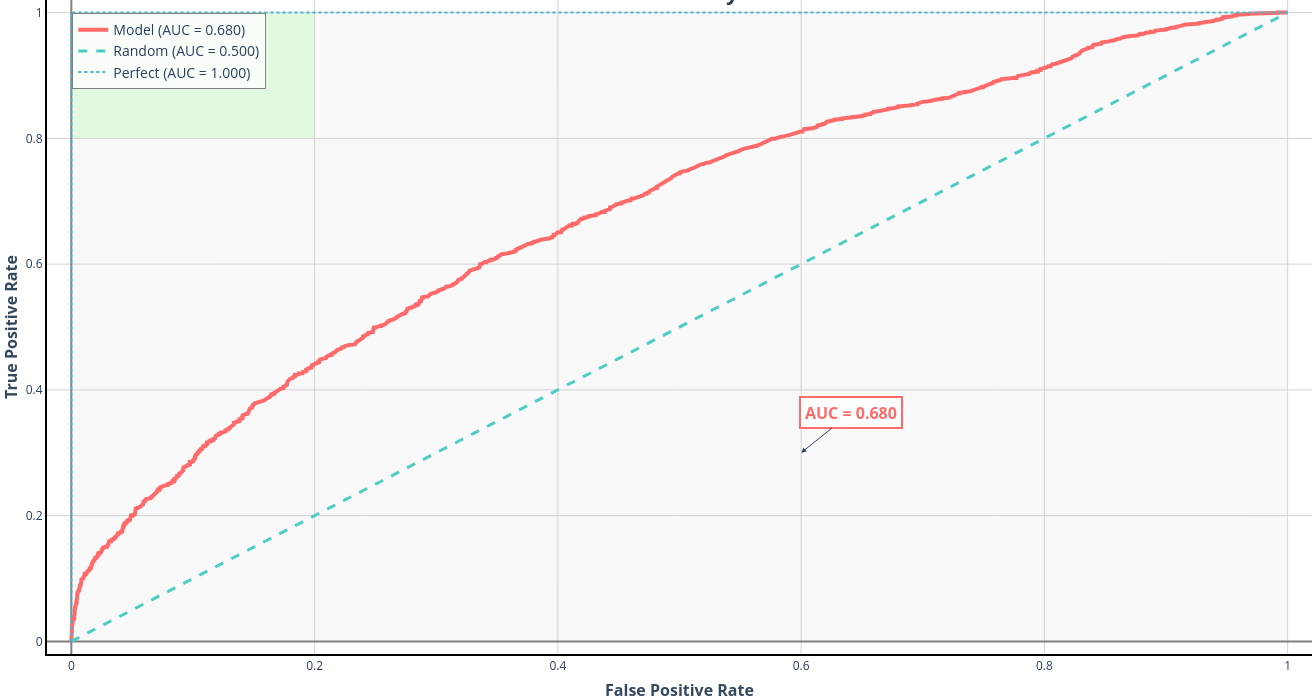

✅ Custom Plotly graph logged to wandb


In [7]:
fig.show()

print("✅ Custom Plotly graph logged to wandb")

In [8]:

wandb.init(project="france-hvac", id=run_id, resume="allow")

cm = confusion_matrix(y_test, y_pred)

# Minimal combined plot
fig = make_subplots(rows=2, cols=2)

# ROC
fig.add_trace(go.Scatter(x=fpr, y=tpr, name='ROC'), row=1, col=1)
# fig.add_trace(go.Scatter(x=[0,1], y=[0,1], name='Random', line=dict(dash='dash')), row=1, col=1)

# Confusion Matrix
fig.add_trace(go.Heatmap(z=cm, x=['0','1'], y=['0','1'], text=cm, texttemplate='%{text}'), row=1, col=2)


fig.add_trace(go.Scatter(x=fpr, y=tpr, name='ROC'), row=2, col=1)
# fig.add_trace(go.Scatter(x=[0,1], y=[0,1], name='Random', line=dict(dash='dash')), row=1, col=1)

# Confusion Matrix
fig.add_trace(go.Heatmap(z=cm, x=['0','1'], y=['0','1'], text=cm, texttemplate='%{text}'), row=2, col=2)


fig.update_layout(width=900, height=900)
wandb.log({"_plots/simple_combined": fig})

In [9]:
# wandb.init(project="france-hvac", id=run_id, resume="allow")
# # Minimal combined plot
# fig = make_subplots(rows=1, cols=1)

# # ROC
# fig.add_trace(go.Scatter(x=fpr, y=tpr, name='ROC'), row=1, col=1)
# # fig.add_trace(go.Scatter(x=[0,1], y=[0,1], name='Random', line=dict(dash='dash')), row=1, col=1)

# # # Confusion Matrix
# # fig.add_trace(go.Heatmap(z=cm, x=['0','1'], y=['0','1'], text=cm, texttemplate='%{text}'), row=1, col=2)


# # fig.add_trace(go.Scatter(x=fpr, y=tpr, name='ROC'), row=2, col=1)
# # # fig.add_trace(go.Scatter(x=[0,1], y=[0,1], name='Random', line=dict(dash='dash')), row=1, col=1)

# # # Confusion Matrix
# # fig.add_trace(go.Heatmap(z=cm, x=['0','1'], y=['0','1'], text=cm, texttemplate='%{text}'), row=2, col=2)


# fig.update_layout(width=900, height=900)
# wandb.log({"_plots/roc": fig})

In [10]:
wandb.init(project="france-hvac", id=run_id, resume="allow")
# Minimal combined plot
fig = make_subplots(rows=1, cols=1)

# ROC
# fig.add_trace(go.Scatter(x=fpr, y=tpr, name='ROC'), row=1, col=1)
# fig.add_trace(go.Scatter(x=[0,1], y=[0,1], name='Random', line=dict(dash='dash')), row=1, col=1)

# # Confusion Matrix
# fig.add_trace(go.Heatmap(z=cm, x=['0','1'], y=['0','1'], text=cm, texttemplate='%{text}'), row=1, col=2)


# fig.add_trace(go.Scatter(x=fpr, y=tpr, name='ROC'), row=2, col=1)
# # fig.add_trace(go.Scatter(x=[0,1], y=[0,1], name='Random', line=dict(dash='dash')), row=1, col=1)

# Confusion Matrix
fig.add_trace(go.Heatmap(z=cm, x=['0','1'], y=['0','1'], text=cm, texttemplate='%{text}'), row=1, col=1)


fig.update_layout(width=900, height=900)
wandb.log({"_plots/confusion_matrix": fig})

In [11]:
# Log ROC and Confusion Matrix for customer model
auc_customer = plot_and_log_roc(y_test, y_pred_proba, "customer_model")
plot_and_log_confusion_matrix(y_test, y_pred, "customer_model")

# Log single metric (clean, no automatic charts)
# wandb.log({
#     "customer_auc": auc_customer,
#     "customer_accuracy": accuracy_score(y_test, y_pred),
#     "customer_f1": f1_score(y_test, y_pred, zero_division=0)
# })

print(f"  ✓ Customer AUC: {auc_customer:.3f}")
print(f"  ✓ ROC & Confusion Matrix logged to wandb")

# Test 2: Sequence features
print("\n🧪 SEQUENCE FEATURES MODEL")
result_sequence = train_rf(X_sequence_clean, y_sequence_clean, 'sequence_model')

# Create predictions for sequence model
X_train_seq, X_test_seq, y_train_seq, y_test_seq = train_test_split(
    X_sequence_clean, y_sequence_clean, test_size=0.2, random_state=42
)
y_pred_seq = result_sequence['model'].predict(X_test_seq)
y_pred_proba_seq = result_sequence['model'].predict_proba(X_test_seq)[:, 1]

# Log ROC and Confusion Matrix for sequence model
auc_sequence = plot_and_log_roc(y_test_seq, y_pred_proba_seq, "sequence_model")
plot_and_log_confusion_matrix(y_test_seq, y_pred_seq, "sequence_model")

# # Log single metric
# wandb.log({
#     "sequence_auc": auc_sequence,
#     "sequence_accuracy": accuracy_score(y_test_seq, y_pred_seq),
#     "sequence_f1": f1_score(y_test_seq, y_pred_seq, zero_division=0)
# })

print(f"  ✓ Sequence AUC: {auc_sequence:.3f}")
print(f"  ✓ ROC & Confusion Matrix logged to wandb")

# Create comparison bar chart (only one extra chart)
print("\n📊 CREATING MODEL COMPARISON")
fig, ax = plt.subplots(figsize=(8, 6))
models = ['Customer', 'Sequence']
aucs = [auc_customer, auc_sequence]

bars = ax.bar(models, aucs, color=['skyblue', 'lightcoral'])
ax.set_ylabel('AUC Score')
ax.set_title('Model AUC Comparison')
ax.set_ylim([0, 1])

# Add value labels on bars
for bar, auc in zip(bars, aucs):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{auc:.3f}', ha='center', va='bottom')

# Log comparison chart
# wandb.log({"model_comparison": wandb.Image(fig)})
plt.close(fig)

# # Log final summary
# wandb.run.summary["best_model"] = "Sequence" if auc_sequence > auc_customer else "Customer"
# wandb.run.summary["best_auc"] = max(auc_customer, auc_sequence)
# wandb.run.summary["improvement"] = auc_sequence - auc_customer

print("\n" + "="*80)
print("RESULTS SUMMARY")
print("="*80)
print(f"Customer Model AUC: {auc_customer:.3f}")
print(f"Sequence Model AUC: {auc_sequence:.3f}")
print(f"Improvement: {auc_sequence - auc_customer:.3f}")


  ✓ Customer AUC: 0.680
  ✓ ROC & Confusion Matrix logged to wandb

🧪 SEQUENCE FEATURES MODEL
✓ Model saved: sequence_model.pkl
✓ AUC: 0.738
  ✓ Sequence AUC: 0.786
  ✓ ROC & Confusion Matrix logged to wandb

📊 CREATING MODEL COMPARISON

RESULTS SUMMARY
Customer Model AUC: 0.680
Sequence Model AUC: 0.786
Improvement: 0.106
